# Lab 9
## Introduction to Artificial Neural Networks with Keras

In [8]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(71)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Perceptrons

In [9]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=71)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [10]:
y_pred

array([1])

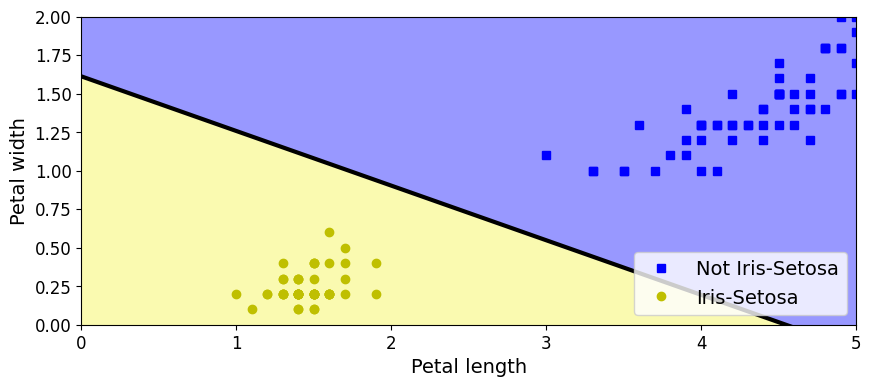

In [11]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

## Activation functions

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

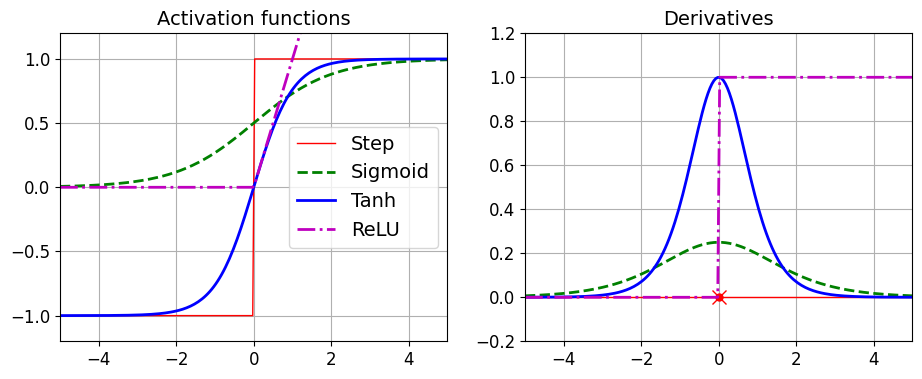

In [13]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [14]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

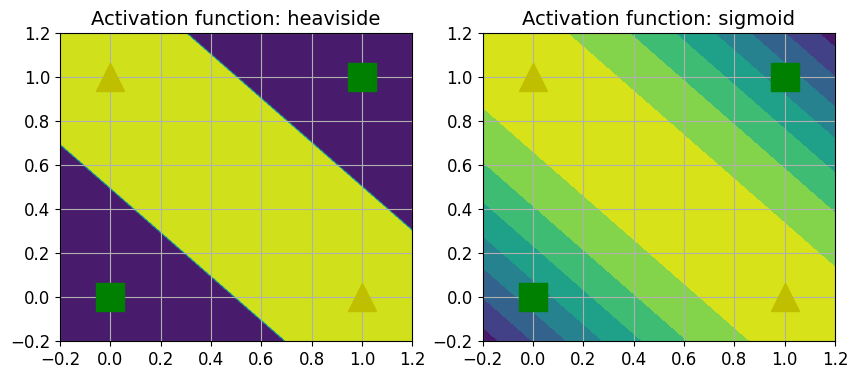

In [15]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## 10.
 Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the error, and finding the point where the error shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [17]:
# Load data
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df = pd.read_csv("sample_data/kc_house_data.csv")

houses_num = df.drop("date", axis=1).drop("floors", axis=1).drop("bathrooms", axis=1)
num_attribs = list(houses_num)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
    ])

houses = full_pipeline.fit_transform(df)
labels = np.array([int(x) for x in df["floors"]]).copy()

print(houses.shape)
print(labels.shape)

(21613, 18)
(21613,)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(houses, labels, test_size=0.2, random_state=71)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size = 0.25)
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))

(12967, 18)
(12967,)
[1 2 3]


Train model for 300 epochs

In [21]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

model = keras.models.Sequential([
    keras.layers.Dense(18, input_shape=(18,), activation='relu'),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation='sigmoid')
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-8),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=300, callbacks=[lr_scheduler])

Epoch 1/300
406/406 [==============================] - 4s 3ms/step - loss: 0.7765 - accuracy: 0.0553 - val_loss: 0.7740 - val_accuracy: 0.0599 - lr: 1.0000e-08
Epoch 2/300
406/406 [==============================] - 1s 3ms/step - loss: 0.7761 - accuracy: 0.0554 - val_loss: 0.7736 - val_accuracy: 0.0606 - lr: 1.1220e-08
Epoch 3/300
406/406 [==============================] - 1s 3ms/step - loss: 0.7757 - accuracy: 0.0556 - val_loss: 0.7732 - val_accuracy: 0.0606 - lr: 1.2589e-08
Epoch 4/300
406/406 [==============================] - 1s 3ms/step - loss: 0.7753 - accuracy: 0.0558 - val_loss: 0.7727 - val_accuracy: 0.0608 - lr: 1.4125e-08
Epoch 5/300
406/406 [==============================] - 1s 3ms/step - loss: 0.7748 - accuracy: 0.0560 - val_loss: 0.7722 - val_accuracy: 0.0613 - lr: 1.5849e-08
Epoch 6/300
406/406 [==============================] - 1s 3ms/step - loss: 0.7743 - accuracy: 0.0561 - val_loss: 0.7716 - val_accuracy: 0.0613 - lr: 1.7783e-08
Epoch 7/300
406/406 [===================

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30)
checkpoint_cb = keras.callbacks.ModelCheckpoint("houses_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=300, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/300
406/406 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/300
406/406 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/300
406/406 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/300
406/406 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/300
406/406 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/300
406/406 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/300
406/406 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accura